In [1]:
import numpy as np
import mpmath as mp
import renormalization as rg
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
mp.mp.dps = 30
mp.mp.pretty = False

# Transfer matrix for spin-s Ising model

In [3]:
s = .5

T = 1
t = rg.transfer_matrix(s, 1/T)
print(t)

[                             1.0  0.135335283236612691893999494972]
[0.135335283236612691893999494972                               1.0]


# Renormalization group flow

In [10]:
s = 0.5 # Spin number s
T = .1 # Temperature 1/J

p = 0.5 # Antiferromagnetic bond concentration
N = 500 # Bond population
n = 10 # RG iteration number

# Ferro and antiferro transfer matrices
ferro  = rg.transfer_matrix(s,  1/T)
aferro = rg.transfer_matrix(s, -1/T)

t_list = []
for _ in range(int((1 - p) * N)):
    t_list.append(ferro)
for _ in range(int(p * N)):
    t_list.append(aferro)

ij = 19
j = rg.interaction(t_list[ij])
X = rg.interaction(t_list[ij]) / rg.average_interaction_strength(t_list)

print("k    J(ij)/<|J|>      J(ij) \n")
print(0, "   ", X, "             ", j)

flow = [[0, X]]
for k in range(1, n):
    
    t_list = rg.renormalize(N, t_list)
    
    j = rg.interaction(t_list[ij])
    j_absavr = rg.average_interaction_strength(t_list)
    X = j / j_absavr
    flow.append([k, X])
    print(f"{k}     {mp.nstr(X, 5)}        {mp.nstr(j, 5)}")
    
flow = np.array(flow)

k    J(ij)/<|J|>      J(ij) 

0     1.0               10.0
1     -2.403        -29.653
2     -0.76311        -11.792
3     -3.5026        -67.725
4     1.8605        46.785
5     0.15658        4.8271
6     -0.94733        -38.14
7     -0.053476        -2.9976
8     0.12521        9.411
9     -2.2598        -222.66


## Trajectory plot

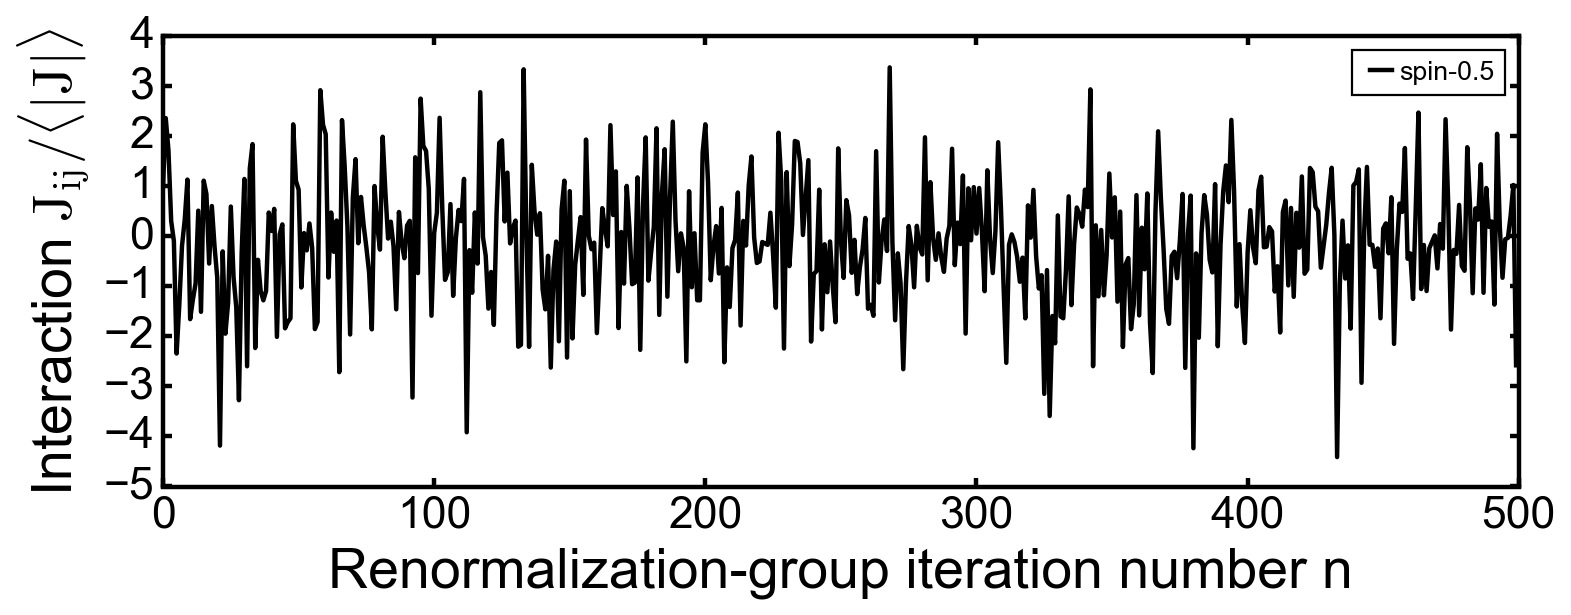

In [9]:
lw = 2
fs = 20
fig = plt.figure(figsize=(10, 4))
fig.set_facecolor('none')
plt.style.use('classic')
plt.rc('lines', linewidth=lw)
plt.rc('axes', linewidth=lw)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'mathtext.default':'regular'})

ax = plt.subplot(111)
ax.plot(flow[:,0], flow[:,1], linestyle='-', marker='', markersize=10, label="spin-" + str(s), color='black')

ax.legend(loc='upper right', ncol=1, prop={'size':fs - 8}, labelspacing=0.5, handlelength=1.4, handletextpad=0)
ax.tick_params(axis="both", direction="in", left=True, width=lw, length=4, labelsize=fs)
ax.set_xlabel(r"Renormalization-group iteration number n", fontsize=fs)
ax.set_ylabel(r"Interaction $\mathrm{J_{ij} / \langle |J| \rangle}$", fontsize=fs)
plt.tight_layout()
plt.show()
#fig.savefig('chaotic_flow', bbox_inches="tight")

# Lyapunov exponent

In [35]:
s = 0.5 # Spin number s
T = 0.5 # Temperature 1/J

p = 0.5 # Antiferromagnetic bond concentration
N = 500 # Bond population
n = 100 # RG iteration number

# Ferro and antiferro transfer matrices
ferro  = rg.transfer_matrix(s,  1/T)
aferro = rg.transfer_matrix(s, -1/T)

t_list = []
for _ in range(int((1 - p) * N)):
    t_list.append(ferro)
for _ in range(int(p * N)):
    t_list.append(aferro)

ij = 19
j = rg.interaction(t_list[ij])
X = rg.interaction(t_list[ij]) / rg.average_interaction_strength(t_list)

print(f"""
Spin number s = {s}
Temparature 1/J = {T}
Bond population N = {N}
Antiferromagnetic bond concentration p = {p}
=============================================
""")
print("k     λ         X")
print("_________________")
print(f"{0}     {mp.nan}      {X}")

flow = [[0, X]]
lyapunov_list = [[0, mp.nan]]

eps = 0.0001

for k in range(1, n):
    
    t_list_ = rg.renormalize(N, t_list, seed=19)

    # Averages: <|J|> and <|J'|>
    j_avr  = rg.average_interaction_strength(t_list)
    j_avr_ = rg.average_interaction_strength(t_list_)

    # Define deviation for trajectory at step k
    delta = eps * j_avr
    tdelta = rg.transfer_matrix(s, delta)

    # Deviated t_list
    deviated_t_list = []
    for i in range(N):      
        ti = rg.mp_multiply(t_list[i], tdelta)
        deviated_t_list.append(ti)

    # Renormalize deviated transfer matrix list
    deviated_t_list_ = rg.renormalize(N, deviated_t_list, seed=19)

    # Derivation: dX(k+1)/dX(k), X(k):=J(ij)/<|J|>
    j_ = rg.interaction(t_list_[ij])
    dj_ = rg.interaction(deviated_t_list_[ij])
    j_delta = np.absolute(j_ - dj_)
    derivative = (j_delta / delta) * (j_avr / j_avr_)

    # Log of derivative
    if derivative == 0.0 or mp.isnan(derivative):
        ly = mp.nan
        lyapunov_list.append([k, ly])
    else:
        ly = mp.log(derivative)
        lyapunov_list.append([k, ly])
    
    j_absavr_ = rg.average_interaction_strength(t_list_)
    X = j_ / j_absavr_
    flow.append([k, X])

    print(f"{k}     {mp.nstr(ly, 5)}     {mp.nstr(X, 5)}")

    # Recover the renormalized list
    t_list = t_list_


Spin number s = 0.5
Temparature 1/J = 0.5
Bond population N = 500
Antiferromagnetic bond concentration p = 0.5

k     λ         X
_________________
0     nan      1.0
1     2.0266     0.8436
2     1.9026     0.31615
3     1.6103     -0.13311
4     1.9164     0.24098
5     1.8998     0.37821
6     1.9404     0.64408
7     1.9437     2.5354
8     1.8843     -2.1158
9     1.9092     0.40564
10     1.9387     0.53523
11     1.9274     -0.80343
12     1.852     -0.40669
13     1.9293     0.29205
14     1.8889     -1.0678
15     1.9063     0.22908
16     1.9261     -2.0407
17     1.9006     0.67474
18     2.0102     -0.41808
19     1.9676     0.1856
20     1.9781     0.051101
21     1.8974     2.2513
22     1.9186     -1.4757
23     1.9015     -0.87725
24     2.0241     -0.49214
25     1.9073     0.8631
26     1.8999     1.8851
27     1.8701     0.14328
28     1.8942     0.080747
29     1.9688     0.60904
30     1.9862     2.5915
31     1.9378     -0.41816
32     1.8244     0.67014
33     1

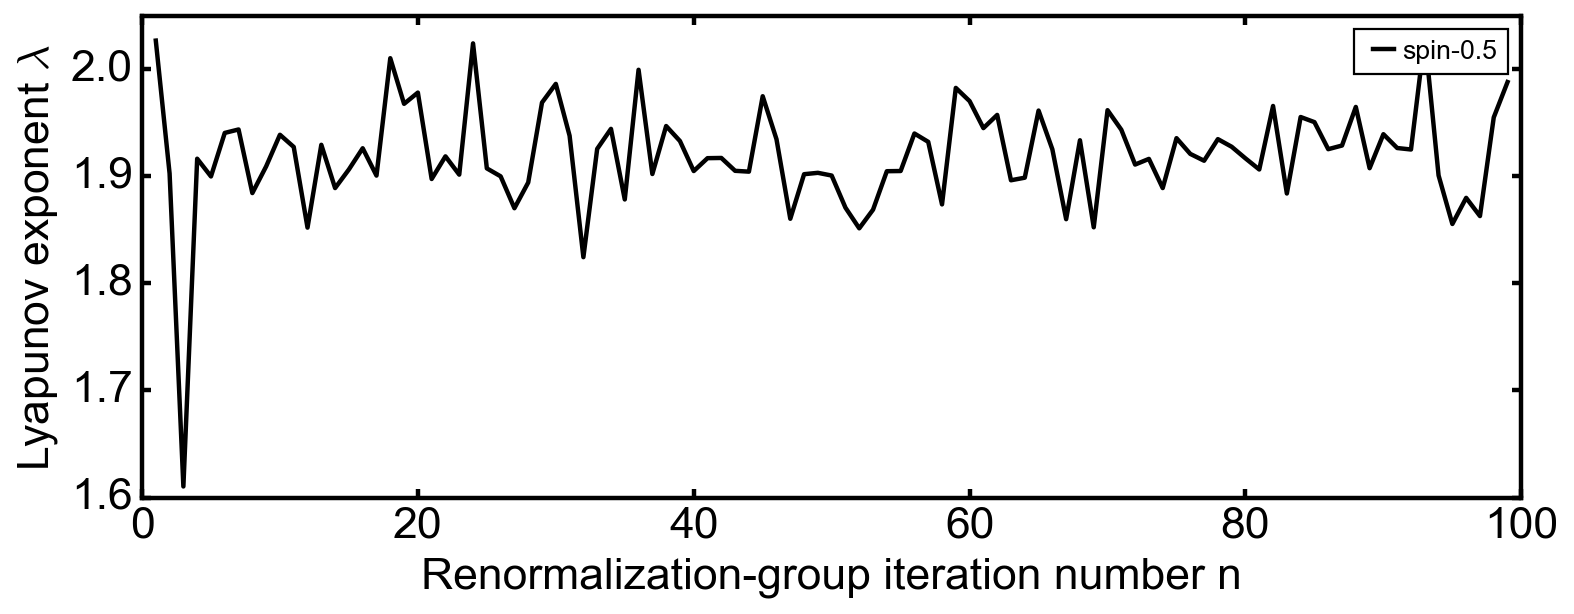

In [55]:
lyapunov_list = np.array(lyapunov_list)

lw = 2
fs = 20
fig = plt.figure(figsize=(10, 4), layout='tight')
fig.set_facecolor('none')
plt.style.use('classic')
plt.rc('lines', linewidth=lw)
plt.rc('axes', linewidth=lw)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'mathtext.default':'regular'})

ax = plt.subplot(111)
ax.plot(lyapunov_list[1:,0], lyapunov_list[1:,1], linestyle='-', marker='', markersize=10, label="spin-" + str(s), color='black')
ax.legend(loc='upper right', ncol=1, prop={'size':fs - 8}, labelspacing=0.5, handlelength=1.4, handletextpad=0)
ax.tick_params(axis="both", direction="in", left=True, width=lw, length=4, labelsize=fs)
ax.set_xlabel(r"Renormalization-group iteration number n", fontsize=fs)
ax.set_ylabel(r"Lyapunov exponent $\mathrm{\lambda}$", fontsize=fs)
plt.show()
#fig.savefig('chaotic_flow', bbox_inches="tight")

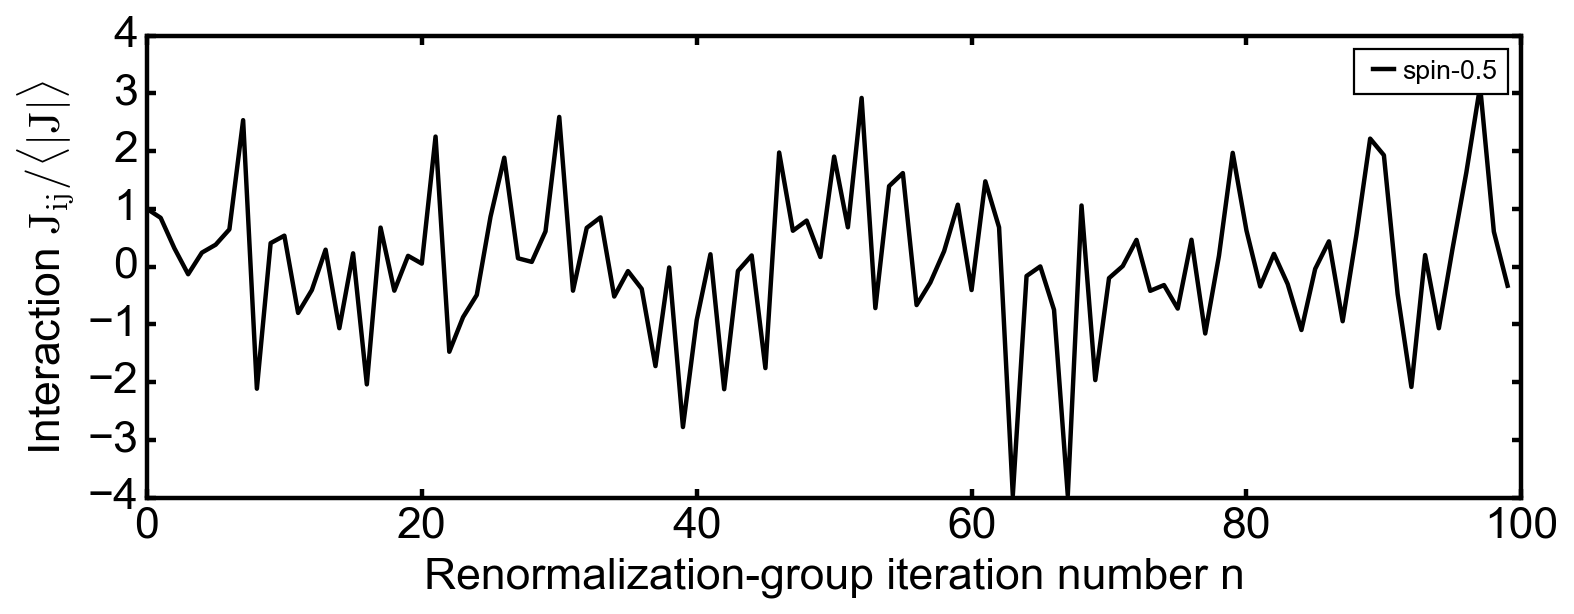

In [57]:
flow = np.array(flow)

lw = 2
fs = 20
fig = plt.figure(figsize=(10, 4), layout='tight')
fig.set_facecolor('none')
plt.style.use('classic')
plt.rc('lines', linewidth=lw)
plt.rc('axes', linewidth=lw)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'mathtext.default':'regular'})

ax = plt.subplot(111)
ax.plot(flow[:,0], flow[:,1], linestyle='-', marker='', markersize=10, label="spin-" + str(s), color='black')
ax.legend(loc='upper right', ncol=1, prop={'size':fs - 8}, labelspacing=0.5, handlelength=1.4, handletextpad=0)
ax.tick_params(axis="both", direction="in", left=True, width=lw, length=4, labelsize=fs)
ax.set_xlabel(r"Renormalization-group iteration number n", fontsize=fs)
ax.set_ylabel(r"Interaction $\mathrm{J_{ij} / \langle |J| \rangle}$", fontsize=fs)
plt.show()
#fig.savefig('chaotic_flow', bbox_inches="tight")